In [ ]:
import os
import numpy as np
import pandas as pd
import regex as re

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pip install bracketology

  Created wheel for bracketology: filename=bracketology-0.0.99-py3-none-any.whl size=30416 sha256=9bd0788b6494c8e8c6c2ecabea81d278144adfd2663afa5f5dc2c05f748315bb
  Stored in directory: /root/.cache/pip/wheels/ac/9e/6e/acfdd77b5a9406ac5ef7cfe513053c6ee00086b1cf1980d19a
Successfully built bracketology


# Creation of the Main Dataframe

In [ ]:
heights = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/height21.csv")

In [ ]:
miscDef = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/misc21Defense.csv")

In [ ]:
miscOff = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/misc21Offense.csv")

In [ ]:
miscOff=miscOff.add_prefix("Offensive_")
miscOff= miscOff.rename(columns={"Offensive_Season":"Season", "Offensive_TeamName":"TeamName"})

In [ ]:
miscDef = miscDef.add_prefix("Defensive_")
miscDef = miscDef.rename(columns={"Defensive_Season":"Season","Defensive_TeamName":"TeamName"})

In [ ]:
final_data_frame = pd.concat([miscOff,miscDef,heights],axis=1)

In [ ]:
final_data_frame = final_data_frame.loc[:,~final_data_frame.columns.duplicated()]

# Main Functions

In [ ]:
def clean_opponent_name(dataframe):
  clean_opponent_list = []
  pattern = r"[(\d)]"
  for team in dataframe.index:
    clean_opponent = re.sub(pattern,"",dataframe["Opponent"][team])
    clean_opponent = clean_opponent.replace("()","")
    if clean_opponent == "North Carolina State":
      clean_opponent = "N.C. State"
    if clean_opponent =="Florida State" or clean_opponent == "Florida State ":
      clean_opponent ="Florida St."
    
    clean_opponent = clean_opponent.strip()
    clean_opponent_list.append(clean_opponent)
  dataframe["Official Opponent"] = clean_opponent_list
  dataframe = dataframe.drop(columns=["Opponent"],axis=1)
  return dataframe

In [ ]:
def grab_stats(offensive_factors, defensive_factors, team_name):
  offense_factors = offensive_factors[offensive_factors["TeamName"]== team_name]
  offense_factors = offense_factors.drop(["RankeFGPct","RankTOPct","RankORPct","RankFTRate","Season", "TeamName"],axis =1)
  defense_factors = defensive_factors[defensive_factors["TeamName"]== team_name]
  defense_factors = defense_factors.drop(["RankeFGPct","RankTOPct","RankORPct","RankFTRate","Season","TeamName"],axis =1)
  return offense_factors.values.tolist()[0], defense_factors.values.tolist()[0]

In [ ]:
def grab_misc_stats(dataframe, team_name):
  dataframe = dataframe[dataframe.columns.drop(list(dataframe.filter(regex='Rank')))]
  misc_stats = dataframe[dataframe["TeamName"] == team_name]
  return misc_stats[["Exp","Bench","Size"]].values.tolist()

In [ ]:
def return_final_dataframe(dataframe,team_name):
  offense_stats, defense_stats = grab_stats(offensive_four_factors_2020_2021,defensive_four_factors_2020_2021,team_name)
  tm_misc_stats = grab_misc_stats(final_data_frame,team_name)
  new_dataframe = dataframe[["Unnamed: 4","Official Opponent","Tm","Opp"]]
  new_dataframe[["Opp Off eFG%","Opp Off TOP%","Opp Off ORB%", "Opp Off FTR%"]] = np.NaN
  new_dataframe[["Opp Def eFG%","Opp Def TOP%","Opp Def ORB%", "Opp Def FTR%"]] = np.NaN
  for index,row in new_dataframe.iterrows():
    try:
      opponent_off_fac, opponent_def_fac = grab_stats(offensive_four_factors_2020_2021, defensive_four_factors_2020_2021, row["Official Opponent"])
      opponent_misc_stats = grab_misc_stats(final_data_frame, row["Official Opponent"])
      
      final_list = opponent_off_fac + opponent_def_fac + opponent_misc_stats[0]
      new_dataframe.at[ index, "Opp Off eFG%"] = final_list[0]
      new_dataframe.at[ index, "Opp Off TOP%"] = final_list[1]
      new_dataframe.at[ index, "Opp Off ORB%"] = final_list[2]
      new_dataframe.at[ index, "Opp Off FTR%"] = final_list[3]
      new_dataframe.at[ index, "Opp Def eFG%"] = final_list[4]
      new_dataframe.at[ index, "Opp Def TOP%"] = final_list[5]
      new_dataframe.at[ index, "Opp Def ORB%"] = final_list[6]
      new_dataframe.at[ index, "Opp Def FTR%"] = final_list[7]
      new_dataframe.at[ index, "Opp Exp"] = final_list[8]
      new_dataframe.at[ index, "Opp Bench"] = final_list[9]
      new_dataframe.at[ index, "Opp Size"] = final_list[10]
    except IndexError:
      continue
  total_stats = offense_stats + defense_stats + tm_misc_stats[0]
  new_dataframe["tm Off eFG%"] = total_stats[0]
  new_dataframe["tm Off TOP%"] = total_stats[1]
  new_dataframe["tm Off ORB%"] = total_stats[2]
  new_dataframe["tm Off FTR%"] = total_stats[3]
  new_dataframe["tm Def eFG%"] = total_stats[4]
  new_dataframe["tm Def TOP%"] = total_stats[5]
  new_dataframe["tm Def ORB%"] = total_stats[6]
  new_dataframe["tm Def FTR%"] = total_stats[7]
  new_dataframe["tm Exp"] = total_stats[8]
  new_dataframe["tm Bench"] = total_stats[9]
  new_dataframe["tm Size"] = total_stats[10]
  new_dataframe["Final Point Differential"] = new_dataframe["Tm"] - new_dataframe["Opp"]
  new_dataframe = new_dataframe.drop(columns=['Unnamed: 4','Official Opponent'])
  new_dataframe = new_dataframe.dropna()
  new_dataframe = new_dataframe.drop(['Tm'], axis=1)
  new_dataframe = new_dataframe.drop(['Opp'], axis=1)
  return new_dataframe

# ACC Table

In [ ]:
UNC_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/UNC2020_2021.csv")
Duke_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Duke2020_2021.csv")
UVA_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/UVA2020_2021.csv")
NCState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/NCState2020_2021.csv")
BostonCollege_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/BostonCollege2020_2021.csv")
Clemson2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Clemson2020_2021.csv")
FloridaState2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/FloridaState2020_2021.csv")
GeorgiaTech2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/GeorgiaTech2020_2021.csv")
Louisville2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Louisville2020_2021.csv")
Miami2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Miami2020_2021.csv")
Pittsburgh2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Pittsburgh2020_2021.csv")
Syracuse2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Syracuse2020_2021.csv")
WakeForest2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/WakeForest2020_2021.csv")
VirginiaTech2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/VirginiaTech2020_2021.csv")

In [ ]:
offensive_four_factors_2020_2021 = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/offense21.csv")
defensive_four_factors_2020_2021 = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/defense21.csv")

In [ ]:
UNC_2020_2021_cleaned = clean_opponent_name(UNC_2020_2021_basic)
Duke_2020_2021_cleaned = clean_opponent_name(Duke_2020_2021_basic)
UVA_2020_2021_cleaned = clean_opponent_name(UVA_2020_2021_basic)
NCState_2020_2021_cleaned = clean_opponent_name(NCState_2020_2021_basic)
BostonCollege_2020_2021_cleaned = clean_opponent_name(BostonCollege_2020_2021_basic)
Clemson_2020_2021_cleaned = clean_opponent_name(Clemson2020_2021_basic)
FloridaState_2020_2021_cleaned = clean_opponent_name(FloridaState2020_2021_basic)
GeorgiaTech_2020_2021_cleaned = clean_opponent_name(GeorgiaTech2020_2021_basic)
Louisville_2020_2021_cleaned = clean_opponent_name(Louisville2020_2021_basic)
Miami_2020_2021_cleaned = clean_opponent_name(Miami2020_2021_basic)
Pittsburgh_2020_2021_cleaned = clean_opponent_name(Pittsburgh2020_2021_basic)
Syracuse_2020_2021_cleaned = clean_opponent_name(Syracuse2020_2021_basic)
WakeForest_2020_2021_cleaned = clean_opponent_name(WakeForest2020_2021_basic)
VirginiaTech_2020_2021_cleaned = clean_opponent_name(VirginiaTech2020_2021_basic)


# Big10

In [ ]:
Illinois_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Illinois2020_2021.csv")
Indiana_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Indiana2020_2021csv.csv")
Iowa_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Iowa2020_2021.csv")
Maryland_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Maryland2020_2021.csv")
Michigan_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Michigan2020_2021.csv")
MichiganState2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/MichiganState2020_2021.csv")
Minnesota2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Minnesota2020_2021.csv")
Nebraska2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Nebraska2020_2021.csv")
Northwestern2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Northwestern2020_2021.csv")
OhioState2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/OhioState2020_2021.csv")
PennState2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/PennState2020_2021.csv")
Purdue2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Purdue2020_2021.csv")
Rutgers2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Rutgers2020_2021.csv")
Wisconsin2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Wisconsin2020_2021.csv")

In [ ]:
Illinois_2020_2021_cleaned = clean_opponent_name(Illinois_2020_2021_basic)
Indiana_2020_2021_cleaned = clean_opponent_name(Indiana_2020_2021_basic)
Iowa_2020_2021_cleaned = clean_opponent_name(Iowa_2020_2021_basic)
Maryland_2020_2021_cleaned = clean_opponent_name(Maryland_2020_2021_basic)
Michigan_2020_2021_cleaned = clean_opponent_name(Michigan_2020_2021_basic)
MichiganState2020_2021_cleaned = clean_opponent_name(MichiganState2020_2021_basic)
Minnesota2020_2021_cleaned = clean_opponent_name(Minnesota2020_2021_basic)
Nebraska2020_2021_cleaned = clean_opponent_name(Nebraska2020_2021_basic)
Northwestern2020_2021_cleaned = clean_opponent_name(Northwestern2020_2021_basic)
OhioState2020_2021_cleaned = clean_opponent_name(OhioState2020_2021_basic)
PennState2020_2021_cleaned = clean_opponent_name(PennState2020_2021_basic)
Purdue2020_2021_cleaned = clean_opponent_name(Purdue2020_2021_basic)
Rutgers2020_2021_cleaned = clean_opponent_name(Rutgers2020_2021_basic)
Wisconsin2020_2021_cleaned = clean_opponent_name(Wisconsin2020_2021_basic)

#Big12

In [ ]:
Baylor_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/WestVirginia2020_2021.csv")
IowaState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/IowaState2020_2021.csv")
Kansas_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/Kansas2020_2021.csv")
KansasState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/KansasState2020_2021.csv")
Oklahoma_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/Oklahoma2020_2021.csv")
OklahomaState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/OklahomaState2020_2021.csv")
TCU_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/TCU2020_2021.csv")
Texas_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/Texas2020_2021.csv")
TexasTech_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/TexasTech2020_2021.csv")
WestVirginia_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/WestVirginia2020_2021.csv")

In [ ]:
Baylor_2020_2021_cleaned = clean_opponent_name(Baylor_2020_2021_basic)
IowaState_2020_2021_cleaned = clean_opponent_name(IowaState_2020_2021_basic)
Kansas_2020_2021_cleaned = clean_opponent_name(Kansas_2020_2021_basic)
KansasState_2020_2021_cleaned = clean_opponent_name(KansasState_2020_2021_basic)
Oklahoma_2020_2021_cleaned = clean_opponent_name(Oklahoma_2020_2021_basic)
OklahomaState_2020_2021_cleaned = clean_opponent_name(OklahomaState_2020_2021_basic)
TCU_2020_2021_cleaned = clean_opponent_name(TCU_2020_2021_basic)
Texas_2020_2021_cleaned = clean_opponent_name(Texas_2020_2021_basic)
TexasTech_2020_2021_cleaned = clean_opponent_name(TexasTech_2020_2021_basic)
WestVirginia_2020_2021_cleaned = clean_opponent_name(WestVirginia_2020_2021_basic)


# SEC

In [ ]:
Alabama_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Alabama2020_2021.csv")
Arkansas_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Arkansas2020_2021.csv")
Auburn_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Auburn2020_2021.csv")
Kentucky_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Kentucky2020_2021.csv")
Florida_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Florida2020_2021.csv")
Georgia_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Georgia2020_2021.csv")
LSU_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/LSU2020_2021.csv")
MississippiState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/MississippiState2020_2021.csv")
Missouri_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Missouri2020_2021.csv")
oleMiss_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/oleMiss2020_2021.csv")
SouthCarolina_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/SouthCarolina2020_2021.csv")
Tennessee_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Tennessee2020_2021.csv")
TexasAM_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/TexasAM2020_2021.csv")
Vanderbilt_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Vanderbilt2020_2021.csv")

In [ ]:
Alabama_2020_2021_cleaned = clean_opponent_name(Alabama_2020_2021_basic)
Arkansas_2020_2021_cleaned = clean_opponent_name(Arkansas_2020_2021_basic)
Auburn_2020_2021_cleaned = clean_opponent_name(Auburn_2020_2021_basic)
Kentucky_2020_2021_cleaned = clean_opponent_name(Kentucky_2020_2021_basic)
Florida_2020_2021_cleaned = clean_opponent_name(Florida_2020_2021_basic)
Georgia_2020_2021_cleaned = clean_opponent_name(Georgia_2020_2021_basic)
LSU_2020_2021_cleaned = clean_opponent_name(LSU_2020_2021_basic)
MississippiState_2020_2021_cleaned = clean_opponent_name(MississippiState_2020_2021_basic)
Missouri_2020_2021_cleaned = clean_opponent_name(Missouri_2020_2021_basic)
oleMiss_2020_2021_cleaned = clean_opponent_name(oleMiss_2020_2021_basic)
SouthCarolina_2020_2021_cleaned = clean_opponent_name(SouthCarolina_2020_2021_basic)
Tennessee_2020_2021_cleaned = clean_opponent_name(Tennessee_2020_2021_basic)
TexasAM_2020_2021_cleaned = clean_opponent_name(TexasAM_2020_2021_basic)
Vanderbilt_2020_2021_cleaned = clean_opponent_name(Vanderbilt_2020_2021_basic)

# PAC-12

In [ ]:
Arizona_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Arizona2020_2021.csv")
ArizonaState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/ArizonaState2020_2021.csv")
California_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/California2020_2021.csv")
ColoradoState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/ColoradoState2020_2021.csv")
Oregon_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Oregon2020_2021.csv")
OregonState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/OregonState2020_2021.csv")
Standford_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Standford2020_2021.csv")
UCLA_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/UCLA2020_2021.csv")
USC_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/USC2020_2021.csv")
Utah_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Utah2020_2021.csv")
Washington_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Washington2020_2021.csv")
WashingtonState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/WashingtonState2020_2021.csv")

In [ ]:
Arizona_2020_2021_cleaned = clean_opponent_name(Arizona_2020_2021_basic)
ArizonaState_2020_2021_cleaned = clean_opponent_name(ArizonaState_2020_2021_basic)
California_2020_2021_cleaned = clean_opponent_name(California_2020_2021_basic)
ColoradoState_2020_2021_cleaned = clean_opponent_name(ColoradoState_2020_2021_basic)
Oregon_2020_2021_cleaned = clean_opponent_name(Oregon_2020_2021_basic)
OregonState_2020_2021_cleaned = clean_opponent_name(OregonState_2020_2021_basic)
Standford_2020_2021_cleaned = clean_opponent_name(Standford_2020_2021_basic)
UCLA_2020_2021_cleaned = clean_opponent_name(UCLA_2020_2021_basic)
USC_2020_2021_cleaned = clean_opponent_name(USC_2020_2021_basic)
Utah_2020_2021_cleaned = clean_opponent_name(Utah_2020_2021_basic)
Washington_2020_2021_cleaned = clean_opponent_name(Washington_2020_2021_basic)
WashingtonState_2020_2021_cleaned = clean_opponent_name(WashingtonState_2020_2021_basic)

# Final Dataframes

## ACC

In [ ]:
UNC_2020_2021_FINAL = return_final_dataframe(UNC_2020_2021_cleaned,"North Carolina")
Duke_2020_2021_FINAL = return_final_dataframe(Duke_2020_2021_cleaned,"Duke")
UVA_2020_2021_FINAL = return_final_dataframe(UVA_2020_2021_cleaned,"Virginia")
NCState_2020_2021_FINAL = return_final_dataframe(NCState_2020_2021_cleaned,"N.C. State")
BostonCollege_2020_2021_FINAL = return_final_dataframe(BostonCollege_2020_2021_cleaned,"Boston College")
FloridaState_2020_2021_FINAL = return_final_dataframe(FloridaState2020_2021_basic,"Florida St.")
WakeForest_2020_2021_FINAL = return_final_dataframe(WakeForest_2020_2021_cleaned,"Wake Forest")
Clemson_2020_2021_FINAL = return_final_dataframe(Clemson_2020_2021_cleaned,"Clemson")
Pittsburgh_2020_2021_FINAL = return_final_dataframe(Pittsburgh_2020_2021_cleaned,"Pittsburgh")
GeorgiaTech_2020_2021_FINAL = return_final_dataframe(GeorgiaTech_2020_2021_cleaned,"Georgia Tech")
Miami_2020_2021_FINAL = return_final_dataframe(Miami_2020_2021_cleaned,"Miami FL")
Syracuse_2020_2021_FINAL = return_final_dataframe(Syracuse_2020_2021_cleaned,"Syracuse")
VirginiaTech_2020_2021_FINAL = return_final_dataframe(VirginiaTech_2020_2021_cleaned,"Virginia Tech")
Louisville_2020_2021_FINAL = return_final_dataframe(Louisville_2020_2021_cleaned,"Louisville")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
UVA_2020_2021_FINAL

,Opp Off eFG%,Opp Off TOP%,Opp Off ORB%,Opp Off FTR%,Opp Def eFG%,Opp Def TOP%,Opp Def ORB%,Opp Def FTR%,Opp Exp,Opp Bench,...,tm Off ORB%,tm Off FTR%,tm Def eFG%,tm Def TOP%,tm Def ORB%,tm Def FTR%,tm Exp,tm Bench,tm Size,Final Point Differential
0,45.402844,18.354074,34.090909,33.364929,52.624180,15.977877,30.269414,29.334583,1.59,36.01,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,35
1,51.220317,16.911009,24.779736,21.437995,49.775785,19.787031,24.657534,39.910314,1.99,26.51,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,-1
4,46.097046,20.157480,28.571429,31.962025,50.974659,16.942710,31.756757,23.586745,1.17,27.90,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,36
5,61.017812,16.127934,30.070636,35.725191,47.685656,19.311630,23.781009,25.686673,1.54,24.27,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,-23
6,53.887762,15.697579,21.974148,25.895876,50.840841,12.729310,29.793814,19.699700,2.22,20.19,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,9
7,48.975235,20.014976,26.158038,28.522630,54.451167,17.900718,25.909091,32.065687,1.70,38.13,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,9
8,49.789030,19.156790,25.373134,29.704641,55.463576,18.465209,28.656716,29.056291,1.76,33.86,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,12
9,53.887762,15.697579,21.974148,25.895876,50.840841,12.729310,29.793814,19.699700,2.22,20.19,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,12
10,49.962207,19.375415,26.564496,23.204837,48.656126,21.549554,26.937738,28.932806,1.81,37.64,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,35
11,54.064772,16.058697,24.375743,28.420357,52.405498,22.648301,30.382775,28.865979,2.54,20.05,...,22.70195,21.719457,47.993944,15.253058,22.564735,24.753974,1.94,20.04,77.71,2


## Big10

In [ ]:
Illinois_2020_2021_FINAL = return_final_dataframe(Illinois_2020_2021_cleaned,"Illinois")
Indiana_2020_2021_FINAL = return_final_dataframe(Indiana_2020_2021_cleaned,"Indiana")
Iowa_2020_2021_FINAL = return_final_dataframe(Iowa_2020_2021_cleaned,"Iowa")
Maryland_2020_2021_FINAL = return_final_dataframe(Maryland_2020_2021_cleaned,"Maryland")
Michigan_2020_2021_FINAL = return_final_dataframe(Michigan_2020_2021_cleaned,"Michigan")
MichiganState2020_2021_FINAL = return_final_dataframe(MichiganState2020_2021_cleaned,"Michigan St.")
Minnesota2020_2021_FINAL = return_final_dataframe(Minnesota2020_2021_cleaned,"Minnesota")
Nebraska2020_2021_FINAL = return_final_dataframe(Nebraska2020_2021_cleaned,"Nebraska")
Northwestern2020_2021_FINAL = return_final_dataframe(Northwestern2020_2021_cleaned,"Northwestern")
OhioState2020_2021_FINAL = return_final_dataframe(OhioState2020_2021_cleaned,"Ohio St.")
PennState2020_2021_FINAL = return_final_dataframe(PennState2020_2021_cleaned,"Penn St.")
Purdue2020_2021_FINAL = return_final_dataframe(Purdue2020_2021_cleaned,"Purdue")
Rutgers2020_2021_FINAL = return_final_dataframe(Rutgers2020_2021_cleaned,"Rutgers")
Wisconsin2020_2021_FINAL = return_final_dataframe(Wisconsin2020_2021_cleaned,"Wisconsin")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## Big12

In [ ]:
Baylor_2020_2021_FINAL = return_final_dataframe(Baylor_2020_2021_cleaned,"Baylor")
IowaState_2020_2021_FINAL = return_final_dataframe(IowaState_2020_2021_cleaned,"Iowa St.")
Kansas_2020_2021_FINAL = return_final_dataframe(Kansas_2020_2021_cleaned,"Kansas")
KansasState_2020_2021_FINAL = return_final_dataframe(KansasState_2020_2021_cleaned,"Kansas St.")
Oklahoma_2020_2021_FINAL = return_final_dataframe(Oklahoma_2020_2021_cleaned,"Oklahoma")
OklahomaState_2020_2021_FINAL = return_final_dataframe(OklahomaState_2020_2021_cleaned,"Oklahoma St.")
TCU_2020_2021_FINAL = return_final_dataframe(TCU_2020_2021_cleaned,"TCU")
Texas_2020_2021_FINAL = return_final_dataframe(Texas_2020_2021_cleaned,"Texas")
TexasTech_2020_2021_FINAL = return_final_dataframe(TexasTech_2020_2021_cleaned,"Texas Tech")
WestVirginia_2020_2021_FINAL = return_final_dataframe(WestVirginia_2020_2021_cleaned,"West Virginia")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## SEC

In [ ]:
Alabama_2020_2021_FINAL = return_final_dataframe(Alabama_2020_2021_cleaned,"Alabama")
Arkansas_2020_2021_FINAL = return_final_dataframe(Arkansas_2020_2021_cleaned,"Arkansas")
Auburn_2020_2021_FINAL = return_final_dataframe(Auburn_2020_2021_cleaned,"Auburn")
Kentucky_2020_2021_FINAL = return_final_dataframe(Kentucky_2020_2021_cleaned,"Kentucky")
Florida_2020_2021_FINAL = return_final_dataframe(Florida_2020_2021_cleaned,"Florida")
Georgia_2020_2021_FINAL = return_final_dataframe(Georgia_2020_2021_cleaned,"Georgia")
LSU_2020_2021_FINAL = return_final_dataframe(LSU_2020_2021_cleaned,"LSU")
MississippiState_2020_2021_FINAL = return_final_dataframe(MississippiState_2020_2021_cleaned,"Mississippi St.")
Missouri_2020_2021_FINAL = return_final_dataframe(Missouri_2020_2021_cleaned,"Missouri")
oleMiss_2020_2021_FINAL = return_final_dataframe(oleMiss_2020_2021_cleaned,"Mississippi")
SouthCarolina_2020_2021_FINAL = return_final_dataframe(SouthCarolina_2020_2021_cleaned,"South Carolina")
Tennessee_2020_2021_FINAL = return_final_dataframe(Tennessee_2020_2021_cleaned,"Tennessee")
TexasAM_2020_2021_FINAL = return_final_dataframe(TexasAM_2020_2021_cleaned,"Texas A&M")
Vanderbilt_2020_2021_FINAL = return_final_dataframe(Vanderbilt_2020_2021_cleaned,"Vanderbilt")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## PAC-12

In [ ]:
Arizona_2020_2021_FINAL = return_final_dataframe(Arizona_2020_2021_cleaned,"Arizona")
ArizonaState_2020_2021_FINAL = return_final_dataframe(ArizonaState_2020_2021_cleaned,"Arizona St.")
California_2020_2021_FINAL = return_final_dataframe(California_2020_2021_cleaned,"California")
ColoradoState_2020_2021_FINAL = return_final_dataframe(ColoradoState_2020_2021_cleaned,"Colorado St.")
Oregon_2020_2021_FINAL = return_final_dataframe(Oregon_2020_2021_cleaned,"Oregon")
OregonState_2020_2021_FINAL = return_final_dataframe(OregonState_2020_2021_cleaned,"Oregon St.")
Standford_2020_2021_FINAL = return_final_dataframe(Standford_2020_2021_cleaned,"Stanford")
UCLA_2020_2021_FINAL = return_final_dataframe(UCLA_2020_2021_cleaned,"UCLA")
USC_2020_2021_FINAL = return_final_dataframe(USC_2020_2021_cleaned,"USC")
Utah_2020_2021_FINAL = return_final_dataframe(Utah_2020_2021_cleaned,"Utah")
Washington_2020_2021_FINAL = return_final_dataframe(Washington_2020_2021_cleaned,"Washington")
WashingtonState_2020_2021_FINAL = return_final_dataframe(WashingtonState_2020_2021_cleaned,"Washington St.")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

# Team Names

In [ ]:
ACC = ["UNC","UVA","Duke","Louisville","WakeForest","Clemson","Pittsburgh","Syracuse","Clemson","FloridaState","Miami","BostonCollege","GeorgiaTech","VirginiaTech"]
Big10 = ["Illinois","Indiana","Iowa","Maryland","Michigan","MichiganState","Minnesota","Nebraska","Northwestern","OhioState","PennState","Purdue","Rutgers","Wisconsin"]
Big12 = ["Baylor","Iowa State","Kansas","Kansas State","Oklahoma","Oklahoma State","TCU","Texas","Texas Tech","West Virginia"]
SEC = ["Alabama","Arkansas","Auburn","Kentucky","Florida","Georgia","LSU","Mississippi State","Missouri","Ole Miss","South Carolina","Tennessee","Texas A&M","Vanderbilt"]
PAC12=  ["Arizona","Arizona State","California","Colorado State","Oregon","Oregon State","Stanford","UCLA","USC","Utah","Washington","Washington State"]

In [ ]:
final_team_names = ACC + Big10 + Big12 + SEC + PAC12

# Final Dataframes

In [ ]:
list_of_final_dataframes = []
list_of_final_dataframes.append(UNC_2020_2021_FINAL)
list_of_final_dataframes.append(UVA_2020_2021_FINAL)
list_of_final_dataframes.append(Duke_2020_2021_FINAL)
list_of_final_dataframes.append(Louisville_2020_2021_FINAL)
list_of_final_dataframes.append(WakeForest_2020_2021_FINAL)
list_of_final_dataframes.append(Clemson_2020_2021_FINAL)
list_of_final_dataframes.append(Pittsburgh_2020_2021_FINAL)
list_of_final_dataframes.append(Syracuse_2020_2021_FINAL)
list_of_final_dataframes.append(Clemson_2020_2021_FINAL)
list_of_final_dataframes.append(FloridaState_2020_2021_FINAL)
list_of_final_dataframes.append(Miami_2020_2021_FINAL)
list_of_final_dataframes.append(BostonCollege_2020_2021_FINAL)
list_of_final_dataframes.append(GeorgiaTech_2020_2021_FINAL)
list_of_final_dataframes.append(VirginiaTech_2020_2021_FINAL)

list_of_final_dataframes.append(Illinois_2020_2021_FINAL)
list_of_final_dataframes.append(Indiana_2020_2021_FINAL)
list_of_final_dataframes.append(Iowa_2020_2021_FINAL)
list_of_final_dataframes.append(Maryland_2020_2021_FINAL)
list_of_final_dataframes.append(Michigan_2020_2021_FINAL)
list_of_final_dataframes.append(MichiganState2020_2021_FINAL)
list_of_final_dataframes.append(Minnesota2020_2021_FINAL)
list_of_final_dataframes.append(Nebraska2020_2021_FINAL)
list_of_final_dataframes.append(Northwestern2020_2021_FINAL)
list_of_final_dataframes.append(OhioState2020_2021_FINAL)
list_of_final_dataframes.append(PennState2020_2021_FINAL)
list_of_final_dataframes.append(Purdue2020_2021_FINAL)
list_of_final_dataframes.append(Rutgers2020_2021_FINAL)
list_of_final_dataframes.append(Wisconsin2020_2021_FINAL)

list_of_final_dataframes.append(Baylor_2020_2021_FINAL)
list_of_final_dataframes.append(IowaState_2020_2021_FINAL)
list_of_final_dataframes.append(Kansas_2020_2021_FINAL)
list_of_final_dataframes.append(KansasState_2020_2021_FINAL)
list_of_final_dataframes.append(Oklahoma_2020_2021_FINAL)
list_of_final_dataframes.append(OklahomaState_2020_2021_FINAL)
list_of_final_dataframes.append(TCU_2020_2021_FINAL)
list_of_final_dataframes.append(Texas_2020_2021_FINAL)
list_of_final_dataframes.append(TexasTech_2020_2021_FINAL)
list_of_final_dataframes.append(WestVirginia_2020_2021_FINAL)

list_of_final_dataframes.append(Alabama_2020_2021_FINAL)
list_of_final_dataframes.append(Arkansas_2020_2021_FINAL)
list_of_final_dataframes.append(Auburn_2020_2021_FINAL)
list_of_final_dataframes.append(Kentucky_2020_2021_FINAL)
list_of_final_dataframes.append(Florida_2020_2021_FINAL)
list_of_final_dataframes.append(Georgia_2020_2021_FINAL)
list_of_final_dataframes.append(LSU_2020_2021_FINAL)
list_of_final_dataframes.append(MississippiState_2020_2021_FINAL)
list_of_final_dataframes.append(Missouri_2020_2021_FINAL)
list_of_final_dataframes.append(oleMiss_2020_2021_FINAL)
list_of_final_dataframes.append(SouthCarolina_2020_2021_FINAL)
list_of_final_dataframes.append(Tennessee_2020_2021_FINAL)
list_of_final_dataframes.append(TexasAM_2020_2021_FINAL)
list_of_final_dataframes.append(Vanderbilt_2020_2021_FINAL)

list_of_final_dataframes.append(Arizona_2020_2021_FINAL)
list_of_final_dataframes.append(ArizonaState_2020_2021_FINAL)
list_of_final_dataframes.append(California_2020_2021_FINAL)
list_of_final_dataframes.append(ColoradoState_2020_2021_FINAL)
list_of_final_dataframes.append(Oregon_2020_2021_FINAL)
list_of_final_dataframes.append(OregonState_2020_2021_FINAL)
list_of_final_dataframes.append(Standford_2020_2021_FINAL)
list_of_final_dataframes.append(UCLA_2020_2021_FINAL)
list_of_final_dataframes.append(USC_2020_2021_FINAL)
list_of_final_dataframes.append(Utah_2020_2021_FINAL)
list_of_final_dataframes.append(Washington_2020_2021_FINAL)
list_of_final_dataframes.append(WashingtonState_2020_2021_FINAL)

In [ ]:
final_dict = {}
for i in range(len(list_of_final_dataframes)):
  final_dict[final_team_names[i]] = list_of_final_dataframes[i]

In [ ]:
len(final_team_names)

58

In [ ]:
len(list_of_final_dataframes)

64

In [ ]:
Duke_2020_2021_FINAL

,Opp Off eFG%,Opp Off TOP%,Opp Off ORB%,Opp Off FTR%,Opp Def eFG%,Opp Def TOP%,Opp Def ORB%,Opp Def FTR%,Opp Exp,Opp Bench,...,tm Off ORB%,tm Off FTR%,tm Def eFG%,tm Def TOP%,tm Def ORB%,tm Def FTR%,tm Exp,tm Bench,tm Size,Final Point Differential
2,55.318182,17.343229,25.714286,28.181818,55.428571,22.720388,28.618421,28.380952,2.05,24.73,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,22
3,55.552501,18.136325,32.206759,37.932930,46.476241,16.031615,22.127660,30.058729,1.64,28.15,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,-15
4,53.887762,15.697579,21.974148,25.895876,50.840841,12.729310,29.793814,19.699700,2.22,20.19,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,10
5,49.789030,19.156790,25.373134,29.704641,55.463576,18.465209,28.656716,29.056291,1.76,33.86,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,1
6,48.975235,20.014976,26.158038,28.522630,54.451167,17.900718,25.909091,32.065687,1.70,38.13,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,11
7,52.258065,17.183288,27.830832,33.387097,48.842975,17.924528,24.353741,31.900826,1.55,28.51,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,-7
8,48.829953,18.321827,34.487021,36.895476,50.000000,17.458842,26.143791,33.226581,1.27,33.54,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,-6
9,47.774869,17.235540,32.005690,32.111693,48.422436,16.633425,26.164384,29.798422,1.02,21.08,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,-5
10,54.064772,16.058697,24.375743,28.420357,52.405498,22.648301,30.382775,28.865979,2.54,20.05,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,7
11,49.962207,19.375415,26.564496,23.204837,48.656126,21.549554,26.937738,28.932806,1.81,37.64,...,32.227488,23.394185,51.316752,19.883862,28.957055,31.89466,0.86,24.72,77.18,26


# Linear Regression

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
def perform_linear_regression(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["Final Point Differential"].copy()
  x = train_set.drop(columns="Final Point Differential")
  y_test = test_set["Final Point Differential"].copy()
  x_test = test_set.drop(columns="Final Point Differential")
  lin_reg = LinearRegression()
  lin_reg.fit(x,y)
  basketball_predictions = lin_reg.predict(x_test)
  lin_mse = mean_squared_error(y_test, basketball_predictions)
  #sklearn.metrics.f1_score(y_test, basketball_predictions)
  lin_rmse = np.sqrt(lin_mse)
  return lin_rmse

In [ ]:
error_florida = perform_linear_regression(Florida_2020_2021_FINAL)

In [ ]:
error_florida

59.88799909782699

In [ ]:
linear_errors = []
for i in range(len(list_of_final_dataframes)):
  linear_errors.append(perform_linear_regression(list_of_final_dataframes[i]))
#linear_errors

In [ ]:
len(linear_errors)

58

In [ ]:
np.mean(linear_errors)

1176659071735.2527

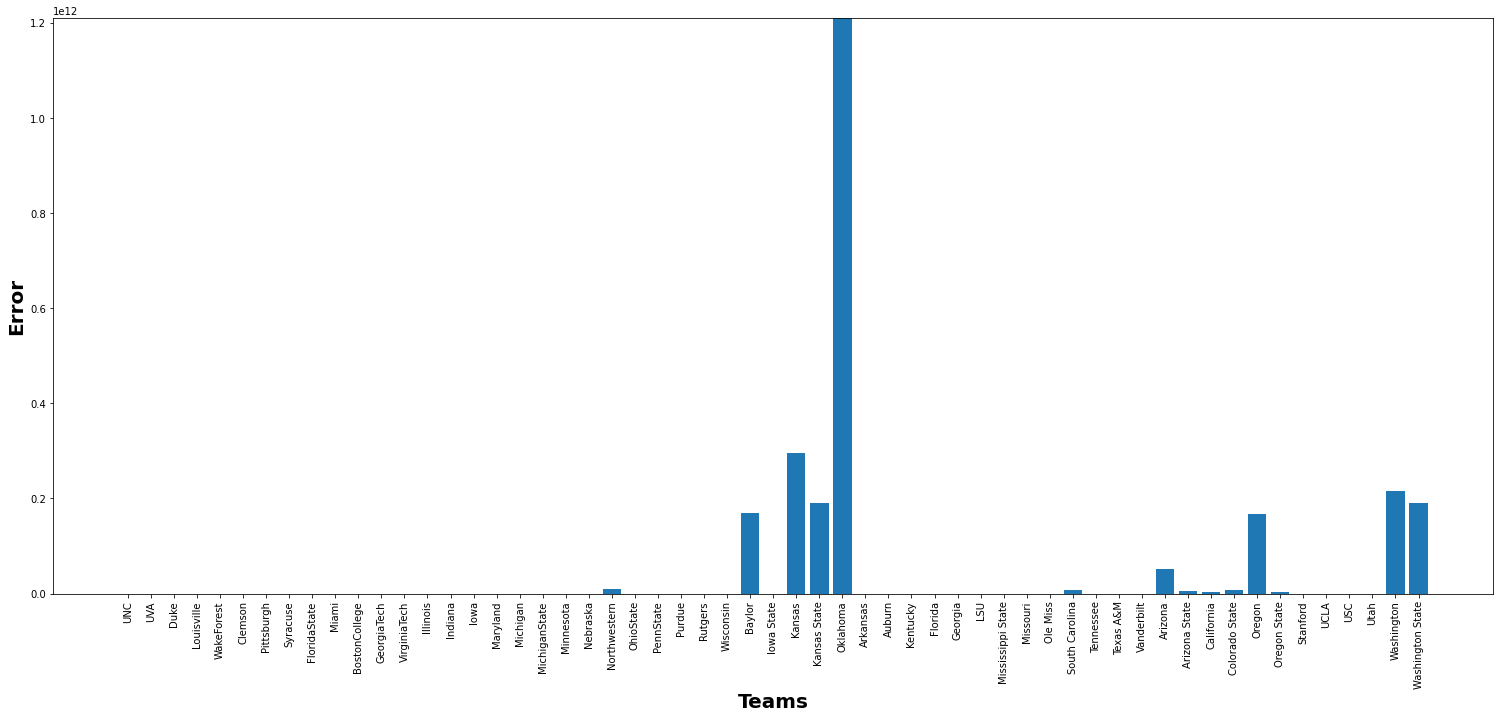

In [ ]:
import matplotlib.pyplot as plt
import math
fig = plt.figure(1, [20,8])
ax = fig.add_axes([0,0,1,1])
temp_final_team_names = final_team_names
temp_linear_errors = linear_errors
temp_final_team_names.pop(33)
temp_linear_errors.pop(33)

plt.bar(temp_final_team_names ,temp_linear_errors)
low = 0
high = max(linear_errors)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.ylim([0, high])
plt.ylabel("Error",fontweight="bold", fontsize=20)
plt.xlabel("Teams", fontweight="bold",fontsize=20)
plt.show()

In [ ]:
def perform_linear_regression(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["Final Point Differential"].copy()
  x = train_set.drop(columns="Final Point Differential")
  y_test = test_set["Final Point Differential"].copy()
  x_test = test_set.drop(columns="Final Point Differential")
  lin_reg = LinearRegression()
  lin_reg.fit(x,y)
  basketball_predictions = lin_reg.predict(x)
  lin_mse = mean_squared_error(y, basketball_predictions)
  lin_rmse = np.sqrt(lin_mse)
  return lin_rmse, basketball_predictions, y

In [ ]:
final_table = pd.concat(list_of_final_dataframes)

In [ ]:
final_table

,Opp Off eFG%,Opp Off TOP%,Opp Off ORB%,Opp Off FTR%,Opp Def eFG%,Opp Def TOP%,Opp Def ORB%,Opp Def FTR%,Opp Exp,Opp Bench,...,tm Off ORB%,tm Off FTR%,tm Def eFG%,tm Def TOP%,tm Def ORB%,tm Def FTR%,tm Exp,tm Bench,tm Size,Final Point Differential
2,51.368925,21.034501,25.059952,36.481862,48.259789,20.251579,28.688525,27.035426,1.34,37.96,...,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,4.0
3,52.876535,20.672106,31.122995,33.872010,46.041799,17.779064,27.458617,35.908803,1.96,27.83,...,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,-2.0
4,54.742478,13.334165,30.803177,31.973483,48.826174,16.100777,29.099678,22.177822,1.70,30.77,...,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,-13.0
5,46.870654,21.392449,26.406926,34.492350,51.035912,20.838240,33.561644,38.259669,2.61,39.50,...,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,6.0
6,47.086721,19.756581,32.644178,34.485095,46.679816,17.945089,30.522946,29.651545,1.00,31.72,...,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,54.237288,16.737499,29.120879,25.968523,50.763845,20.200430,27.650273,26.670910,2.32,28.50,...,30.676085,34.697856,46.613419,18.497839,25.971370,32.715655,1.05,39.38,78.77,3.0
19,52.021563,15.685911,30.451128,31.590296,50.414136,17.495823,25.070159,28.161237,1.38,27.39,...,30.676085,34.697856,46.613419,18.497839,25.971370,32.715655,1.05,39.38,78.77,8.0
21,48.876404,19.228946,23.355263,26.239260,51.200253,17.224803,34.357849,34.680985,1.91,33.18,...,30.676085,34.697856,46.613419,18.497839,25.971370,32.715655,1.05,39.38,78.77,-2.0
23,51.368925,21.034501,25.059952,36.481862,48.259789,20.251579,28.688525,27.035426,1.34,37.96,...,30.676085,34.697856,46.613419,18.497839,25.971370,32.715655,1.05,39.38,78.77,9.0


In [ ]:
lin_rmse, basketball_predictions, y = perform_linear_regression(final_table)

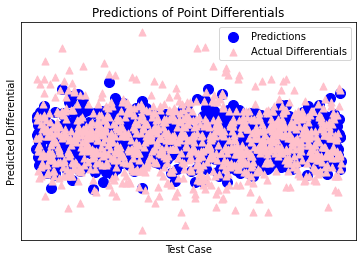

In [ ]:
import matplotlib.pyplot as plt
plt.scatter([x for x in range(len(y))], basketball_predictions, color="blue", marker="o", s=100)
plt.scatter([x for x in range(len(y))], y, color="pink", marker="^", s=50)
#plt.scatter([x for x in range(5)], basketball_predictions, color="blue", marker="o", s=100)
plt.xticks(())
plt.yticks(())
plt.xlabel("Test Case")
plt.ylabel("Predicted Differential")
plt.title("Predictions of Point Differentials")
plt.legend(['Predictions', 'Actual Differentials'])
plt.show()

# Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor(random_state=2)

In [ ]:
def perform_tree(df):
  #df = df.drop(columns="BinaryResult")
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["Final Point Differential"].copy()
  x = train_set.drop(columns="Final Point Differential")
  y_test = test_set["Final Point Differential"].copy()
  x_test = test_set.drop(columns="Final Point Differential")
  tree_reg.fit(x,y)
  scores = cross_val_score(tree_reg, x_test, y_test,
                         scoring="neg_mean_squared_error", cv=2)
  tree_rmse_scores = np.sqrt(-scores)
  return tree_rmse_scores

In [ ]:
average_tree_rmse = []
for i in range(len(list_of_final_dataframes)):
  tree_rmse = perform_tree(list_of_final_dataframes[i])
  average_tree_rmse.append(np.mean(tree_rmse[0]))
#average_tree_rmse

In [ ]:
np.mean(average_tree_rmse)

19.101394692872628

In [ ]:
len(final_team_names)


58

In [ ]:
len(average_tree_rmse)

64

ValueError: ignored

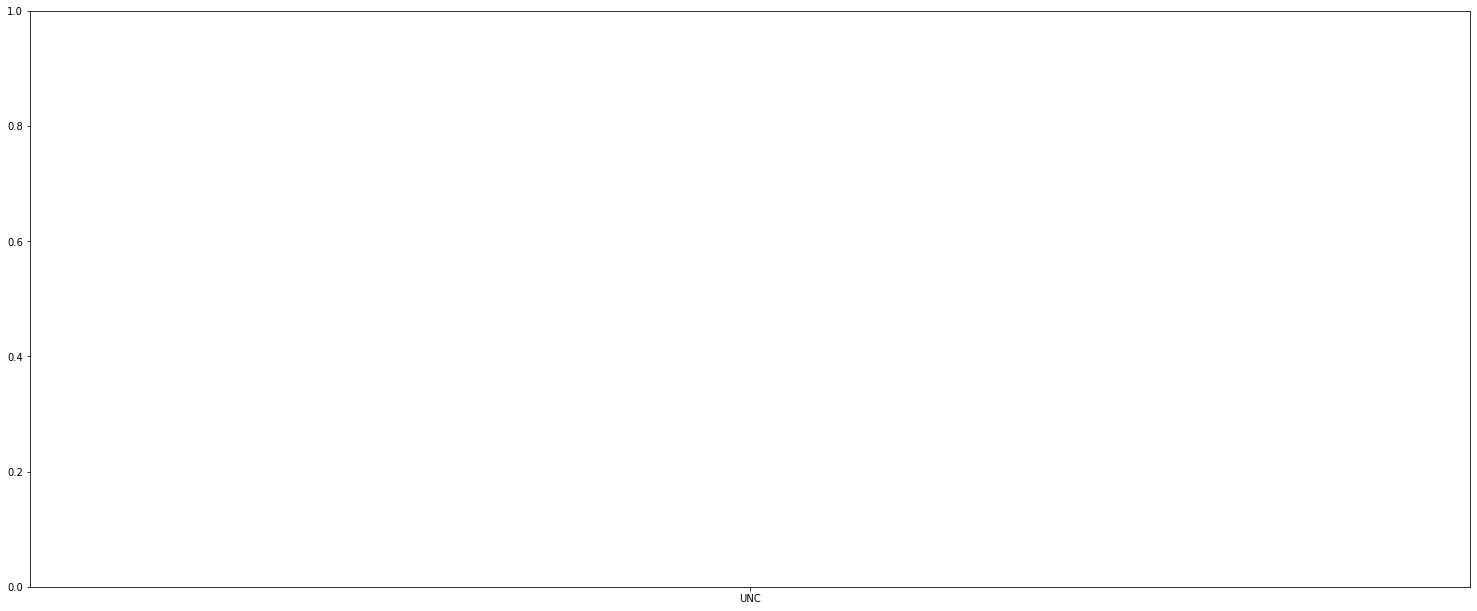

In [ ]:
import matplotlib.pyplot as plt
import math
fig = plt.figure(1, [20,8])
ax = fig.add_axes([0,0,1,1])
plt.bar(final_team_names,average_tree_rmse)
low = 0
high = max(average_tree_rmse)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.ylim([0, high])
plt.ylabel("Error",fontweight="bold", fontsize=20)
plt.xlabel("Teams", fontweight="bold",fontsize=20)
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def perform_random_forest(df):
  #df = df.drop(columns="BinaryResult")
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["Final Point Differential"].copy()
  x = train_set.drop(columns="Final Point Differential")
  y_test = test_set["Final Point Differential"].copy()
  x_test = test_set.drop(columns="Final Point Differential")
  random_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
  random_forest_reg.fit(x,y)
  random_forest_predictions = random_forest_reg.predict(x_test)
  random_tree_mse = mean_squared_error(y_test,random_forest_predictions)
  random_tree_rmse = np.sqrt(random_tree_mse)
  return random_tree_rmse

In [ ]:

random_forest_errors = []
for i in range(len(list_of_final_dataframes)):
  random_forest_errors.append(perform_random_forest(list_of_final_dataframes[i]))
#random_forest_errors
np.mean(random_forest_errors)

14.32164923730064

ValueError: ignored

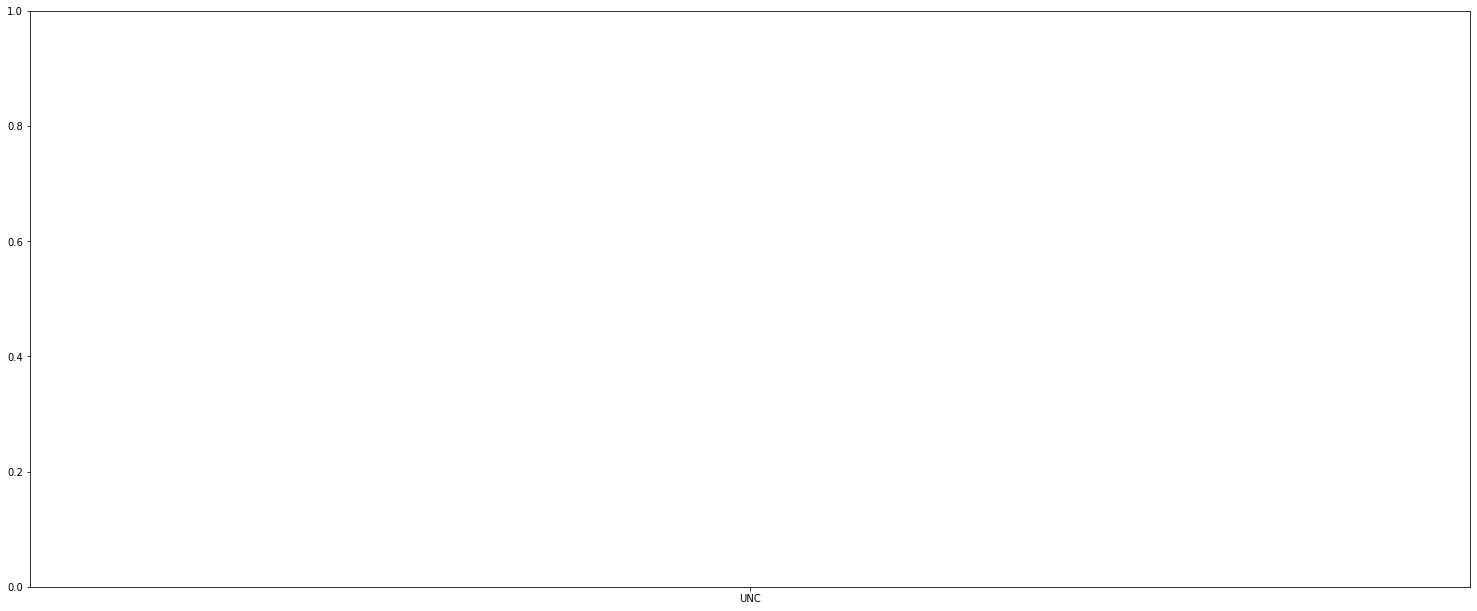

In [ ]:
import matplotlib.pyplot as plt
import math
fig = plt.figure(1, [20,8])
ax = fig.add_axes([0,0,1,1])
plt.bar(final_team_names,random_forest_errors)
low = 0
high = max(random_forest_errors)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.ylim([0, high])
plt.show()

In [ ]:
UNC_2020_2021_FINAL

# Log Reg

In [ ]:
list_log_dataframes = []
for i in range(len(list_of_final_dataframes)):
  log_dataframe = list_of_final_dataframes[i]
  log_dataframe['BinaryResult'] = np.where(log_dataframe['Final Point Differential'] > 0 , 1, 0)
  list_log_dataframes.append(log_dataframe)

In [ ]:


def perform_log(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["BinaryResult"].copy()
  x = train_set.drop(columns="BinaryResult")

  log_reg = LogisticRegressionCV(cv=3,random_state=0, max_iter=1000).fit(x,y)

  
  log_basketball_predictions = log_reg.predict(x)

  log_mse = log_loss(y, log_basketball_predictions)
  return log_mse

In [ ]:
UNC_2020_2021_FINAL

,Opp Off eFG%,Opp Off TOP%,Opp Off ORB%,Opp Off FTR%,Opp Def eFG%,Opp Def TOP%,Opp Def ORB%,Opp Def FTR%,Opp Exp,Opp Bench,...,tm Off FTR%,tm Def eFG%,tm Def TOP%,tm Def ORB%,tm Def FTR%,tm Exp,tm Bench,tm Size,Final Point Differential,BinaryResult
2,51.368925,21.034501,25.059952,36.481862,48.259789,20.251579,28.688525,27.035426,1.34,37.96,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,4,1
3,52.876535,20.672106,31.122995,33.872010,46.041799,17.779064,27.458617,35.908803,1.96,27.83,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,-2,0
4,54.742478,13.334165,30.803177,31.973483,48.826174,16.100777,29.099678,22.177822,1.70,30.77,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,-13,0
5,46.870654,21.392449,26.406926,34.492350,51.035912,20.838240,33.561644,38.259669,2.61,39.50,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,6,1
6,47.086721,19.756581,32.644178,34.485095,46.679816,17.945089,30.522946,29.651545,1.00,31.72,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,12,1
7,52.984551,18.753697,29.647631,31.109551,51.272984,21.557988,31.648616,28.571429,1.60,35.57,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,-3,0
8,54.064772,16.058697,24.375743,28.420357,52.405498,22.648301,30.382775,28.865979,2.54,20.05,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,-5,0
9,53.887762,15.697579,21.974148,25.895876,50.840841,12.729310,29.793814,19.699700,2.22,20.19,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,1,1
10,47.375328,18.415458,27.032735,32.808399,52.546584,17.927990,26.259378,19.751553,1.80,30.00,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,2,1
11,51.249256,16.309835,29.208925,28.316478,48.027842,20.168629,34.022556,24.071926,1.57,19.12,...,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,6,1


In [ ]:
from sklearn.metrics import f1_score
from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import GridSearchCV
def perform_log(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["BinaryResult"].copy()
  x = train_set.drop(columns="BinaryResult")
  
  log_reg = LogisticRegressionCV(cv=4,random_state=0, max_iter=1000).fit(x,y)

  
  log_basketball_predictions = log_reg.predict(x)
  scores = f1_score(y, log_basketball_predictions)
  log_mse = log_loss(y, log_basketball_predictions)
  return log_mse , scores


In [ ]:
log_reg_errors = []
f1_scores_list = []
for i in range(len(list_log_dataframes)):
  if(i == 29):
    continue
  log_error, values= perform_log(list_log_dataframes[i])
  log_reg_errors.append(log_error)
  f1_scores_list.append(values)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selecti

In [ ]:
np.mean(f1_scores_list)

0.9435068752529069

In [ ]:
np.mean(log_reg_errors)

0.596255892458005

In [ ]:
temp_final_team_names_2 = final_team_names
temp_linear_errors_2 = log_reg_errors
temp_final_team_names_2.pop(33)
temp_linear_errors_2.pop(33)


9.992007221626413e-16

In [ ]:
len(final_team_names)

62

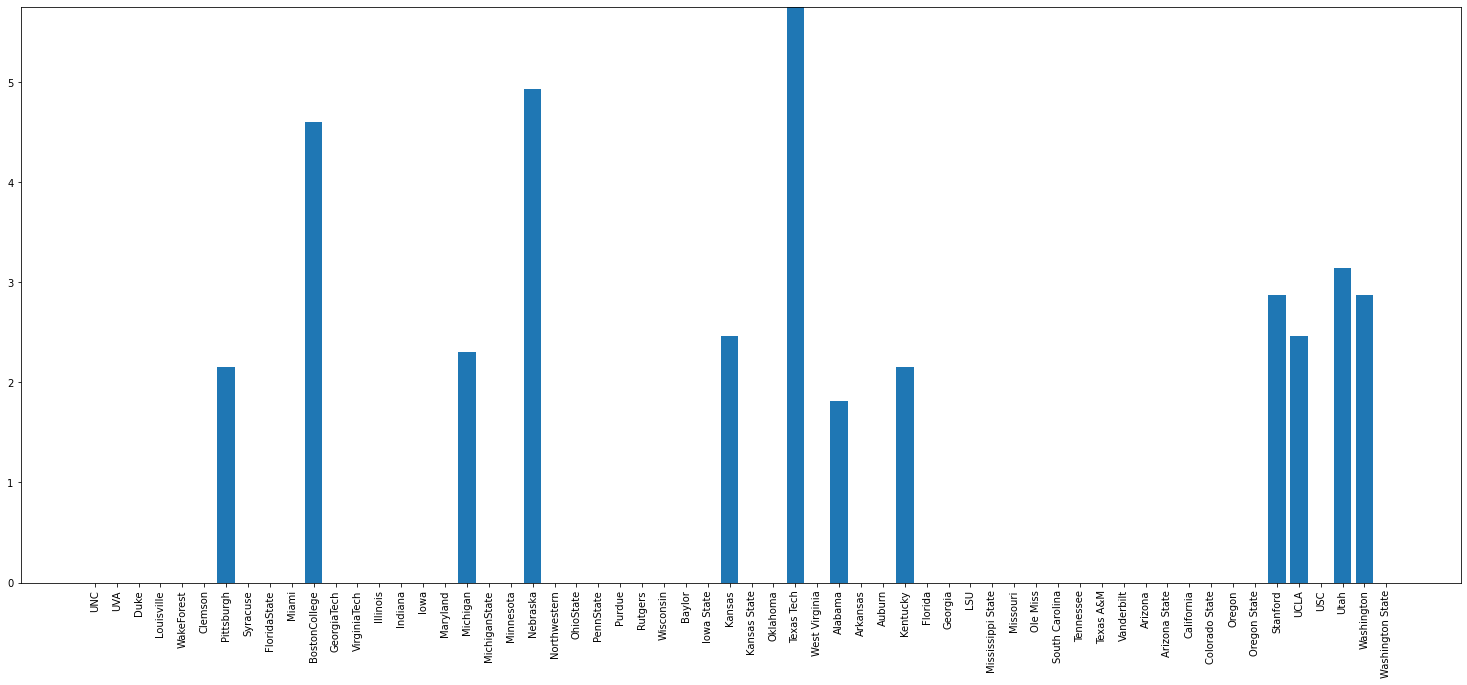

In [ ]:
import matplotlib.pyplot as plt
import math
fig = plt.figure(1, [20,8])
ax = fig.add_axes([0,0,1,1])

temp_final_team_names_2 = final_team_names
temp_linear_errors_2 = log_reg_errors
temp_final_team_names_2.pop(33)
temp_linear_errors_2.pop(33)

plt.bar(temp_final_team_names_2,temp_linear_errors_2)
low = 0
high = max(log_reg_errors)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.ylim([0, high])
plt.show()

# Bracketology

In [ ]:
from bracketology import Bracket, Game, Team

In [ ]:
year = 2019
b19 = Bracket(year)

## Test

In [ ]:
def log_reg_pick(the_game):
    team1 = the_game.top_team
    team2 = the_game.bottom_team
    dataframe_1 = final_dict[team1.name]
    dataframe_2 = final_dict[team2.name]
    
    dataframe_1_select = dataframe_1.iloc[:,11:23]
    dataframe_2_select = dataframe_2.iloc[:,11:23]

    new_column_names_1  = []
    for names in dataframe_1_select.columns:
      if names == "Final Point Differential":
        new_column_names_1.append(names)
      else:
        names = names.replace("tm","Opp")
        new_column_names_1.append(names)
        
    dataframe_1_select.columns = new_column_names_1
    new_column_names_2  = []
    for names in dataframe_2_select.columns:
      if names == "Final Point Differential":
        new_column_names_2.append(names)
      else:
        new_column_names_2.append(names)
    dataframe_2_select.columns = new_column_names_2
    return dataframe_1_select.join(dataframe_2_select, on="Final Point Differential", rsuffix="Other ")

In [ ]:
# Create teams
# High seed is labeled Opp
first = Team(name='Baylor',seed=1)
# Low seed is labeled Tm
second = Team(name='Auburn',seed=2)

# Create a game between the teams
game1 = Game(first, second, round_number=1)

In [ ]:
d = log_reg_pick(game1)
column_means = d.mean()
d = d.fillna(column_means)
d = d.drop(['Final Point DifferentialOther ','Final Point Differential'],axis=1)
d

,Opp Off eFG%,Opp Off TOP%,Opp Off ORB%,Opp Off FTR%,Opp Def eFG%,Opp Def TOP%,Opp Def ORB%,Opp Def FTR%,Opp Exp,Opp Bench,...,tm Off TOP%,tm Off ORB%,tm Off FTR%,tm Def eFG%,tm Def TOP%,tm Def ORB%,tm Def FTR%,tm Exp,tm Bench,tm Size
2,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73
3,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73
4,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73
5,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73
6,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73
8,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73
9,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73
10,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73
12,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73
14,56.54825,16.528332,37.293087,26.511135,48.934227,24.433186,30.608175,31.303289,2.01,28.57,...,21.953979,35.040161,36.179361,49.590164,18.503354,31.805158,31.615925,0.78,33.47,78.73


In [ ]:
def perform_log_prediction(prediction_data,test_data):
  prediction_data = prediction_data.drop(columns=["Final Point Differential"])
  train_set, test_set = train_test_split(prediction_data,test_size = 0.2, random_state = 9)
  y = train_set["BinaryResult"].copy()
  x = train_set.drop(columns="BinaryResult")
  #test_data = test_data.drop(columns=["Final Point Differential", "Final Point DifferentialOther "])
  log_reg = LogisticRegressionCV(cv=2,random_state=0, max_iter=1000).fit(x,y)

  
  log_basketball_predictions = log_reg.predict(test_data)
  
  return log_basketball_predictions

In [ ]:
trial_1 = perform_log_prediction(Auburn_2020_2021_FINAL,d)

In [ ]:
trial_1[0]

0

In [ ]:
import random
def pick_a_random_team(the_game):

    # Extract Teams from Game
    team1 = the_game.top_team
    team2 = the_game.bottom_team

    # Randomly select a winner
    if random.random() < 0.5:
        winner = team1
    else:
        winner = team2

    # Return the lucky team
    return winner

In [ ]:
B22 = Bracket(2022)

ValueError: ignored

In [ ]:
# Initialize simulation parameters
n_sims = 1000 # number of times to simulate through all years
brackets = [b19]
total_sims = (n_sims * len(brackets))
scores = []
correct_games = []

# Loop through a plethora of brackets
for i in range(n_sims):
    for bracket in brackets:

        # Run the algorithm on the bracket
        bracket.score(sim_func=pick_a_random_team, verbose=False)

        # Save the scoring results in a list
        scores.append(bracket.total_score)
        correct_games.append(bracket.n_games_correct)

# Calculate the average across all simulations
avg_score = round(sum(scores) / total_sims)
avg_correct = round(sum(correct_games) / total_sims)

# Print result
print(f"Average number total score {avg_score}/192")
print(f"Average number of games guessed correctly {avg_correct}/64")

Average number total score 31/192
Average number of games guessed correctly 21/64
